### data normalization   


In [162]:
import os
import numpy as np
from glob import glob
import rasterio as rio
from notebooks import config
import matplotlib.pyplot as plt


In [163]:
### secene and truth pairwise data
paths_truth = sorted(glob('data/dset/truth/truth_tif/*.tif'))
paths_scene = sorted(glob('data/dset/scene/scene_ori/*.tif'))
paths_dem = sorted(glob('data/dset/dem/dem_ori/*.tif'))

# paths_scene = [path.replace('truth','scene') for path in paths_truth]
# paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') for path in paths_truth]
id = np.random.randint(0, len(paths_scene))
print(paths_scene[id])
print(paths_dem[id])
print(paths_truth[id]) 


data/dset/scene/scene_ori/l8_scene_12.tif
data/dset/dem/dem_ori/l8_scene_12_dem.tif
data/dset/truth/truth_tif/l8_scene_12.tif


In [164]:
def normalize_with_maxmin(image, max_bands, min_bands):
    '''
    des: normalize each band of the image to [0, 1]
    args:
        image: H*W*C, numpy array
        max_bands: list of max values for each band (or single value for all bands)
        min_bands: list of min values for each band (or single value for all bands)
    '''
    if isinstance(max_bands, (int, float)):
        max_bands = [max_bands] * image.shape[-1]  
    if isinstance(min_bands, (int, float)):
        min_bands = [min_bands] * image.shape[-1]         
    ## normalization
    min_bands_arr = np.array(min_bands).reshape(1, 1, -1)
    max_bands_arr = np.array(max_bands).reshape(1, 1, -1)
    normalized = (image.astype(float) - min_bands_arr) \
                     / (max_bands_arr - min_bands_arr + 1e-6)
    return np.clip(normalized, 0.0, 1.0)  

def normalize_with_percentiles(image, percentiles=(2, 98)):
    '''
    des: normalize each band of the image using the specified percentiles
    args:
        image: H*W*C, numpy array
    '''
    image = image.astype(np.float32)
    p_low, p_high = np.percentile(image, percentiles, axis=(0,1,2))
    image_nor = (image - p_low) / (p_high - p_low + 1e-8)
    image_nor = np.clip(image_nor, 0, 1)
    return image_nor

def normalize_dn2ref(image, scale=0.0001, offset=0):
    '''
    des: convert DN to reflectance
    args:  numpy array
    '''
    image_nor = image.astype(np.float32) * scale + offset
    image_nor = np.clip(image_nor, 0.0, 1.0)
    return image_nor



#### (1) normalization for satellite image
convert DN to surface reflectance. 

In [165]:
for path_scene in paths_scene:
    path_save = path_scene.replace('scene_ori/', 'scene_nor/')
    scene_sat = path_scene.split('/')[-1].split('_')[0]
    scene_rio = rio.open(path_scene)
    profile = scene_rio.profile.copy()
    profile.update(dtype='float32')
    scene_nor = normalize_dn2ref(image=scene_rio.read(), 
                       scale=config.scale[scene_sat], 
                       offset=config.offset[scene_sat])
    # # write to disk
    if os.path.exists(path_save): os.remove(path_save)
    with rio.open(path_save, 'w', **profile) as dst:
        dst.write(scene_nor.astype('float32'))
    print(f'Wrote normalized scene to: {path_save}')
    break  


Wrote normalized scene to: data/dset/scene/scene_nor/l5_scene_01.tif


data/dset/scene/scene_ori/s2_scene_11.tif


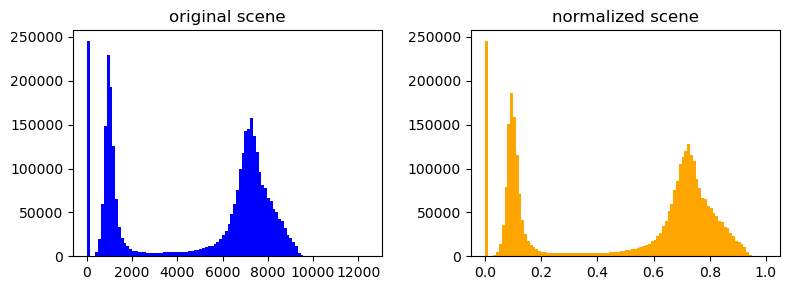

In [157]:
id = 62 
path_scene = paths_scene[id]
print(path_scene)
path_scene_nor = path_scene.replace('scene_ori/', 'scene_nor/')
scene_rio, scene_nor_rio = rio.open(path_scene), rio.open(path_scene_nor)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(scene_rio.read(1).flatten(), bins=100, color='blue');
ax[0].set_title('original scene');
ax[1].hist(scene_nor_rio.read(1).flatten(), bins=100, color='orange');
ax[1].set_title('normalized scene');
plt.tight_layout() 



#### (2) normalization for dem

In [152]:
## normalize dem
for path_dem in paths_dem:
    path_save = path_dem.replace('dem_ori', 'dem_nor')
    dem_rio = rio.open(path_dem)
    profile = dem_rio.profile.copy()
    profile.update(dtype='float32') 
    dem_nor = normalize_with_maxmin(image=dem_rio.read(), 
                                max_bands=config.max_dem, 
                                min_bands=config.min_dem)
    # write to disk
    if os.path.exists(path_save): os.remove(path_save)
    with rio.open(path_save, 'w', **profile) as dst:
        dst.write(dem_nor.astype('float32'))
    print(f'Wrote normalized scene to: {path_save}')
    break 


Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_01_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_02_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_03_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_04_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_05_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_06_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_07_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_08_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_09_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_10_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_11_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_12_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l5_scene_13_dem.tif
Wrote normalized scene to: data/dset/dem/dem_nor/l7_scene_01_dem.tif
Wrote normalized scene to: data/ds

data/dset/dem/dem_ori/l7_scene_10_dem.tif


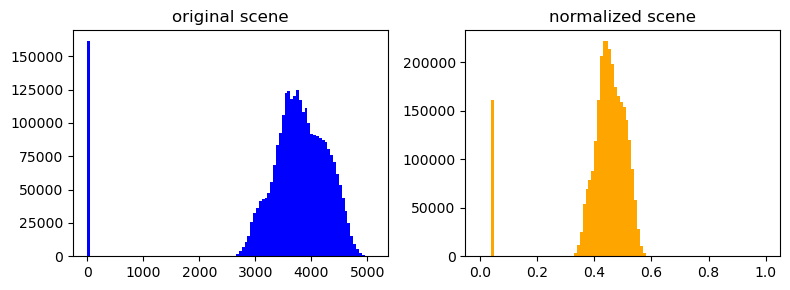

In [161]:
id = 22 
path_dem = paths_dem[id]
print(path_dem)
path_dem_nor = path_dem.replace('dem_ori/', 'dem_nor/')
dem_rio, dem_nor_rio = rio.open(path_dem), rio.open(path_dem_nor)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(dem_rio.read(1).flatten(), bins=100, color='blue');
ax[0].set_title('original scene');
ax[1].hist(dem_nor_rio.read(1).flatten(), bins=100, color='orange', range=(0, 1));
ax[1].set_title('normalized scene');
plt.tight_layout() 

